### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel as C

from specmf.models import Graph, MultiFidelityModel
from specmf.plot import plot_loss_and_kappa, plot_spectrum
from specmf.utils import error_analysis


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data

In [3]:
def _base_signal(x, a, b, c, f, phi, bias):
    """
    Core 1D signal model:
        a * x + b * sin(5π f x + φ) + c * cos(5π x) + bias
    """
    x = np.asarray(x, dtype=float)
    return (
        a * x
        + b * np.sin(5 * np.pi * f * x + phi)
        + c * np.cos(5 * np.pi * x)
        + bias
    )

def func_hf(
    x,
    a: float = 4.0,
    b: float = 1.0,
    c: float = 0.0,
    f: float = 1.0,
    phi: float = 0.0,
):
    """High-fidelity function (no bias term)."""
    return _base_signal(x, a=a, b=b, c=c, f=f, phi=phi, bias=0.0)

def func_lf(
    x,
    a: float = 3.0,
    b: float = 0.85,
    c: float = 0.0,
    f: float = 1.0,
    phi: float = 0.0,
    bias: float = 0.1,
):
    """Low-fidelity function (biased approximation of HF)."""
    return _base_signal(x, a=a, b=b, c=c, f=f, phi=phi, bias=bias)


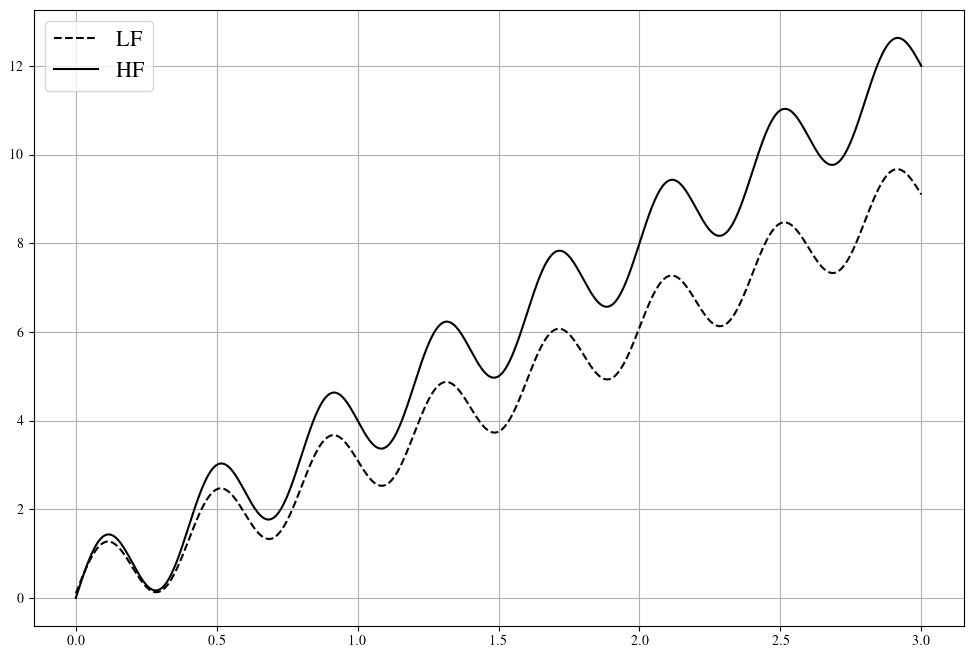

In [27]:
# plot
x_max = 3
x_plot = np.linspace(0, x_max, 1000)
y_lf_plot = func_lf(x_plot)
y_hf_plot = func_hf(x_plot)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x_plot, y_lf_plot, '--k', label='LF')
ax.plot(x_plot, y_hf_plot, 'k', label='HF')
ax.legend(loc='upper left', fontsize=16)
ax.grid(True)


In [28]:
# Data
n_points = 50
x = x_max * np.array([i*(1 / n_points) for i in range(n_points)])
y_lf = func_lf(x)
y_hf = func_hf(x)

x_lf = np.stack((x, y_lf), axis=1)
x_hf = np.stack((x, y_hf), axis=1)

print(f"{x_lf.shape=}", f"{x_hf.shape=}")

x_lf.shape=(50, 2) x_hf.shape=(50, 2)


### Multi-fidelity model

#### Create graph and model instances

In [29]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    # 'k_adj': 2,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_lf, **graph_config)

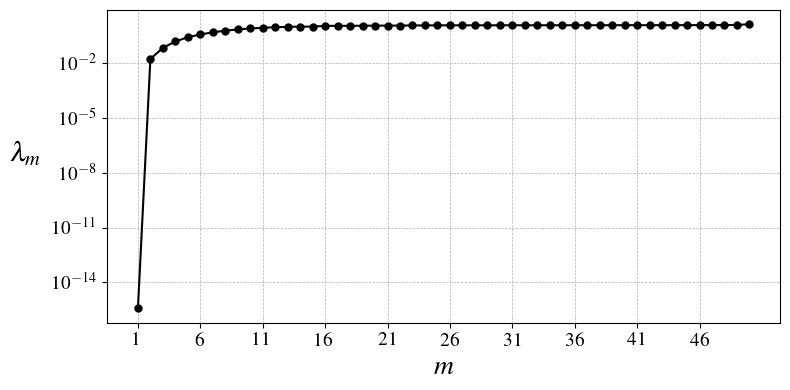

In [30]:
n_HF = 5
inds_train, labels = g_LF.cluster(n_HF)
eigvals, eigvecs = g_LF.laplacian_eig()

plot_spectrum(eigvals, 50)

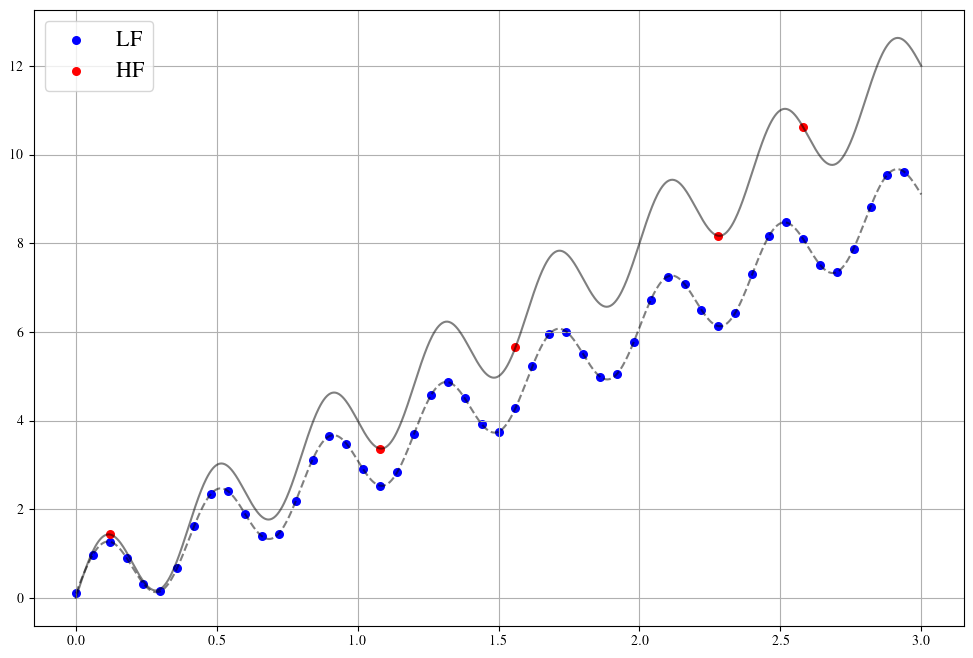

In [31]:
# plot
x_plot = np.linspace(0, x_max, 1000)
y_lf_plot = func_lf(x_plot)
y_hf_plot = func_hf(x_plot)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(x_plot, y_lf_plot, '--k', alpha=0.5)
ax.plot(x_plot, y_hf_plot, 'k', alpha=0.5)
ax.scatter(x_lf[:, 0], x_lf[:, 1], c="blue", marker ="o", s = 30, label='LF',)
ax.scatter(x_hf[inds_train, 0], x_hf[inds_train, 1], c="red", marker ="o", s = 30, label='HF',)
ax.legend(loc='upper left', fontsize=16)
ax.grid(True)

/opt/homebrew/Caskroom/miniforge/base/envs/specmf/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/specmf/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/specmf/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the

Estimated rho: 1.2392845974199889


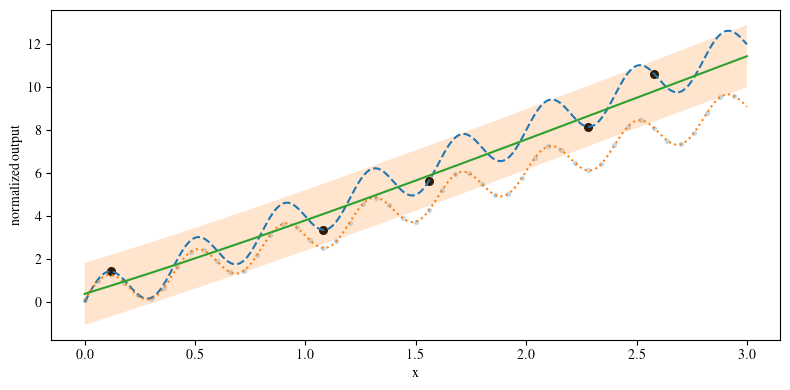

In [34]:
# === Build LF and HF datasets with n_H << n_L ===

# LF: use all points
X_L = x_lf[:, 0:1]
y_L = x_lf[:, 1]

X_H = X_L[inds_train]
y_H = x_hf[inds_train, 1]

# === 1) GP for low-fidelity ===

kernel_L = (
    C(1.0, (1e-3, 1e3))
    * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 1e-2))
)

gp_L = GaussianProcessRegressor(
    kernel=kernel_L,
    normalize_y=True,
    n_restarts_optimizer=5,
    alpha=1e-2,
)
gp_L.fit(X_L, y_L)

# # === 2) Estimate rho on HF subset ===

mu_L_H, _ = gp_L.predict(X_H, return_std=True)
rho = np.dot(mu_L_H, y_H) / np.dot(mu_L_H, mu_L_H)
print("Estimated rho:", rho)

# # === 3) GP for discrepancy delta(x) = y_H - rho * mu_L_H ===

delta = y_H - rho * mu_L_H

kernel_delta = (
    C(1.0, (1e-3, 1e3))
    * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e2))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 1e-2))
)

gp_delta = GaussianProcessRegressor(
    kernel=kernel_delta,
    normalize_y=True,
    n_restarts_optimizer=5,
    alpha=1e-2,
)
gp_delta.fit(X_H, delta)

# # === 4) Predictions on dense grid ===

X_star = x_plot.reshape(-1, 1)

mu_L_star, std_L_star = gp_L.predict(X_star, return_std=True)
mu_delta_star, std_delta_star = gp_delta.predict(X_star, return_std=True)

mu_H_star = rho * mu_L_star + mu_delta_star
var_H_star = (rho**2) * std_L_star**2 + std_delta_star**2  # independence assumption
std_H_star = np.sqrt(var_H_star)

plt.figure(figsize=(8, 4))
plt.plot(x_plot, y_hf_plot, "--", label="True HF (normalized)")
plt.plot(x_plot, y_lf_plot, ":", label="True LF (normalized)")
plt.scatter(X_L[:, 0], y_L, s=8, alpha=0.2, label="LF samples")
plt.scatter(X_H[:, 0], y_H, s=30, color="k", label="HF samples")

plt.plot(X_star[:, 0], mu_H_star, label="Co-kriging HF pred")
plt.fill_between(
    X_star[:, 0],
    mu_H_star - 2 * std_H_star,
    mu_H_star + 2 * std_H_star,
    alpha=0.2,
    label="Co-kriging ±2σ",
)

plt.xlabel("x")
plt.ylabel("normalized output")
plt.tight_layout()
plt.show()


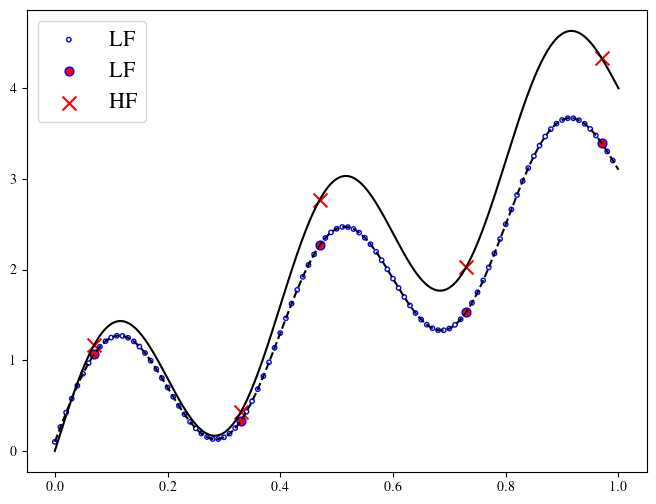

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_lf_plot, '--k')
ax.plot(x_plot, y_hf_plot, 'k')
ax.scatter(x_lf[:, 0], x_lf[:, 1], c="none", marker ="o", edgecolor ="blue", s = 10, label='LF')
ax.scatter(x_lf[inds_train, 0], x_lf[inds_train, 1], c="red", marker ="o", edgecolor ="blue", s = 40, label='LF')
ax.scatter(x_hf[inds_train, 0], x_hf[inds_train, 1], c="red", marker ="x", s = 100, label='HF')
ax.legend(loc='upper left', fontsize=16)

In [11]:
n_samples = x_hf.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_hf[inds_train, :]
x_HF_test = x_hf[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(5, 2) x_HF_test.shape=(95, 2)


#### Fit and train the model

Model Configuration:
sigma              : 0.025
beta               : 2
kappa              : 0.006186427485357445
omega              : 223.37805961377
method             : full
spectrum_cutoff    : None
tau                : 0.005262592061775887


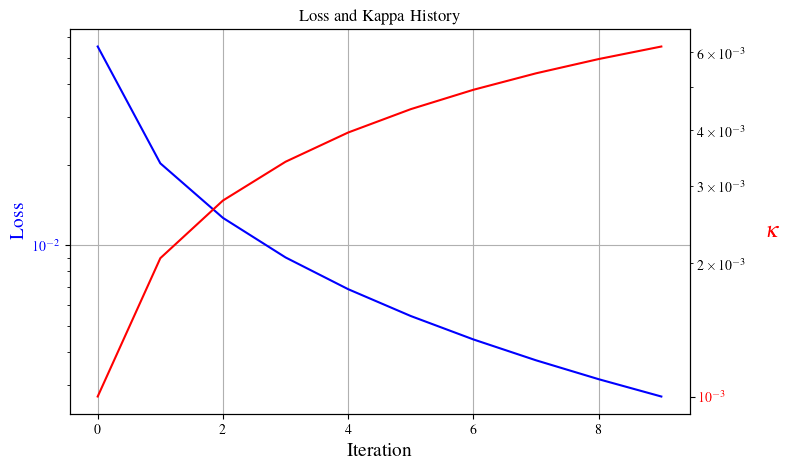

In [12]:

# Create the model 
model_config = {
    'sigma': 0.025,
    'method': 'full'

}
model = MultiFidelityModel(**model_config)

x_MF, C_phi, dPhi, loss_history, kappa_history = model.fit_transform(
    g_LF,
    x_HF_train,
    inds_train,
    maxiter=10,
    step_size=10,
    step_decay_rate=0.99,
    ftol=1e-10,
    verbose=True,
)
model.summary()

plot_loss_and_kappa(loss_history, kappa_history)

### Results

In [13]:
# Error Analysis for the whole dataset
error_analysis(x_lf, x_MF, x_hf)

Mean relative L2 errors and percentage error drop
-------------------------------------------------
Error LF:   19.2 (13.86)
Error MF:   2.51 (1.9)  
[%] drop:   86.93%      


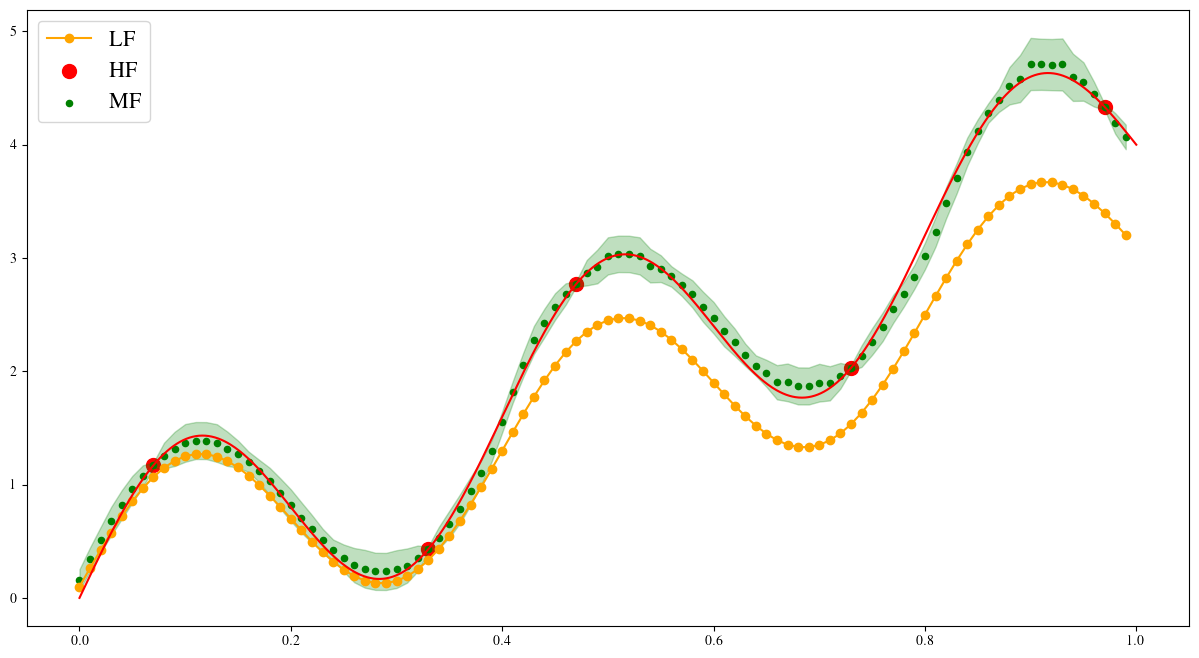

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.plot(x_lf[:, 0], x_lf[:, 1], '-o',label='LF', color='orange')

ax.plot(x_plot, y_hf_plot, 'red')
ax.scatter(x_hf[inds_train, 0], x_hf[inds_train, 1], c="red", marker ="o", s = 100, label='HF')

ax.scatter(x_MF[:, 0], x_MF[:, 1], c="green", marker ="o", s = 20, label='MF')
ax.fill_between(x_MF[:, 0], x_MF[:, 1] - dPhi, x_MF[:, 1] + dPhi, color='green', alpha=0.25)

ax.legend(loc='upper left', fontsize=16)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# ----------------------------
# 1. Define LF and HF functions
# ----------------------------

def _base_signal(x, a, b, c, f, phi, bias):
    x = np.asarray(x, dtype=float)
    return (
        a * x
        + b * np.sin(5 * np.pi * f * x + phi)
        + c * np.cos(5 * np.pi * x)
        + bias
    )

def func_hf(x, a=4.0, b=1.0, c=0.0, f=1.0, phi=0.0):
    """High-fidelity function (no bias)."""
    return _base_signal(x, a=a, b=b, c=c, f=f, phi=phi, bias=0.0)

def func_lf(x, a=3.0, b=0.85, c=0.0, f=1.0, phi=0.0, bias=0.1):
    """Low-fidelity function (biased approximation of HF)."""
    return _base_signal(x, a=a, b=b, c=c, f=f, phi=phi, bias=bias)

# ----------------------------
# 2. Generate multi-fidelity data
# ----------------------------

# Domain
x_min, x_max = 0.0, 1.0

# 50 LF points (cheap)
n_L = 50
X_L = np.linspace(x_min, x_max, n_L).reshape(-1, 1)
y_L = func_lf(X_L[:, 0])

# 5 HF points (expensive) – subset of LF locations
n_H = 5
idx_H = np.linspace(0, n_L - 1, n_H, dtype=int)
X_H = X_L[idx_H]                 # (5, 1)
y_H = func_hf(X_H[:, 0])         # (5,)

print("LF shape:", X_L.shape, y_L.shape)
print("HF shape:", X_H.shape, y_H.shape)

# ----------------------------
# 3. Fit GP to LF data
# ----------------------------

kernel_L = C(1.0) * RBF(length_scale=0.2)

gp_L = GaussianProcessRegressor(
    kernel=kernel_L,
    alpha=1e-6,          # small jitter
    normalize_y=True,
    optimizer=None,      # keep it simple / no hyperparameter optimization
)
gp_L.fit(X_L, y_L)

# ----------------------------
# 4. Estimate rho on HF points
# ----------------------------

mu_L_H, std_L_H = gp_L.predict(X_H, return_std=True)
# least-squares through origin: y_H ≈ rho * mu_L_H
rho = np.dot(mu_L_H, y_H) / np.dot(mu_L_H, mu_L_H)
print("Estimated rho:", rho)

# ----------------------------
# 5. Fit GP to discrepancy delta(x) = y_H - rho * mu_L(x)
# ----------------------------

delta = y_H - rho * mu_L_H

kernel_delta = C(1.0) * RBF(length_scale=0.2)

gp_delta = GaussianProcessRegressor(
    kernel=kernel_delta,
    alpha=1e-6,
    normalize_y=True,
    optimizer=None,
)
gp_delta.fit(X_H, delta)

# ----------------------------
# 6. Co-kriging prediction on a fine grid
# ----------------------------

X_star = np.linspace(x_min, x_max, 400).reshape(-1, 1)

# LF prediction
mu_L_star, std_L_star = gp_L.predict(X_star, return_std=True)

# discrepancy prediction
mu_delta_star, std_delta_star = gp_delta.predict(X_star, return_std=True)

# HF co-kriging prediction
mu_H_star = rho * mu_L_star + mu_delta_star
var_H_star = (rho**2) * (std_L_star**2) + (std_delta_star**2)  # assuming independence
std_H_star = np.sqrt(var_H_star)

# ground truth for reference
y_H_true = func_hf(X_star[:, 0])
y_L_true = func_lf(X_star[:, 0])

# ----------------------------
# 7. Plot
# ----------------------------


LF shape: (50, 1) (50,)
HF shape: (5, 1) (5,)
Estimated rho: 1.2719517664221516


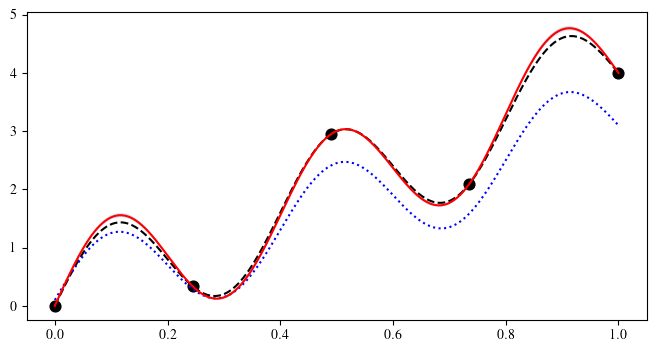

In [40]:

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(X_star[:, 0], y_H_true, "k--", label="True HF")
ax.plot(X_star[:, 0], y_L_true, "b:", label="True LF")

ax.scatter(X_H[:, 0], y_H, s=60, color="k", label="HF samples")

ax.plot(X_star[:, 0], mu_H_star, "r", label="Co-kriging HF pred")
ax.fill_between(
    X_star[:, 0],
    mu_H_star - 2 * std_H_star,
    mu_H_star + 2 * std_H_star, 
    alpha=0.2,
    label="Co-kriging ±2σ",
)

# ax.xlabel("x")
# ax.ylabel("y")
# ax.legend()
# ax.show()